In [13]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SVR,
    SVR_CONFIGSPACE,
    XGB_CONFIGSPACE,
    GPRWithRBF,
    RandomSurvivalForest,
    CoxPHSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    Ridge,
    XGBRegressor,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.split import get_n_splits
from src.wrapper import ScikitLearnWrapper
from src.survival_function_wrapper import SurvivalFunctionWrapper

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


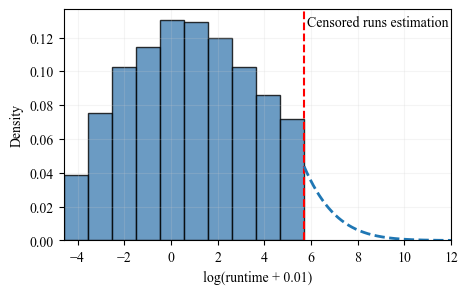

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))

n, bins, patches = ax.hist(
    np.log(df.loc[df["cost"] < 300, "cost"] + 0.01),
    bins=10,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
    density=True,
)
ax.axvline(x=np.log(300 + 0.01), color="red", linestyle="--", label="300 seconds")

z = np.linspace(np.log(300 + 0.01), 12, 1000)
y = 1 - stats.norm.cdf(z, loc=0.75, scale=2.9)
ax.plot(z, y, ls='--', linewidth=2)

ax.set_xlabel('log(runtime + 0.01)')
ax.set_ylabel('Density')
ax.text(8.85, 0.129, "Censored runs estimation", va="center", ha="center")
# plt.savefig("log_runtime_distribution.pdf", bbox_inches="tight")
plt.show()

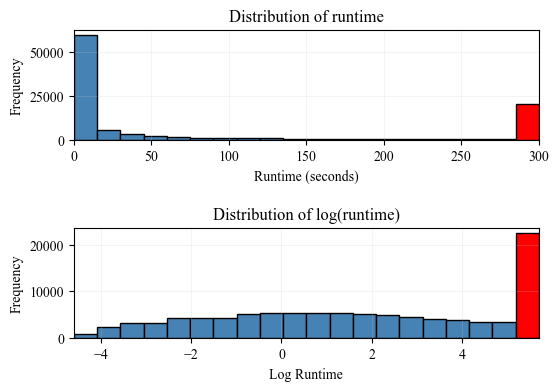

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor('red') 

ax1.set_title('Distribution of runtime')
ax1.set_xlabel('Runtime (seconds)')
ax1.set_ylabel('Frequency')

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor('red') 

ax2.set_title('Distribution of log(runtime)')
ax2.set_xlabel('Log Runtime')
ax2.set_ylabel('Frequency')

plt.subplots_adjust(hspace=0.8)
# plt.savefig("runtime_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
N_TRIALS = 3
N = 2
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 300
RANDOM_STATE = 0

SPLITS = get_n_splits(
    df=df,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)

### Ridge Regression

In [6]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
ridge_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 20 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 50e02f as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'alpha': 0.0002522938648,
 'random_state': 0,
 'model_cls': sklearn.linear_model._ridge.Ridge}

### Polynomial Regression

In [7]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
poly_ridge_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 30 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0f550a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 871091 and rejected config 0f550a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'alpha': 1.8605670525502,
 'degree': 2,
 'interaction_only': False,
 'model_cls': src.configspace.PolynomialRidge}

### Random Forest Regressor

In [8]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
rf_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config f59857 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'max_depth': 10,
 'max_features': 0.6205646954477,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': sklearn.ensemble._forest.RandomForestRegressor}

### XGBoost

In [9]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
xgb_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 100 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config ab76db as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'colsample_bytree': 0.6334392605349,
 'gamma': 3.1028234772384,
 'learning_rate': 0.0144145861178,
 'max_depth': 4,
 'min_child_weight': 9,
 'n_estimators': 501,
 'reg_alpha': 6.9167496732409,
 'reg_lambda': 9.7078357604554,
 'seed': 0,
 'subsample': 0.8860676749609,
 'model_cls': xgboost.sklearn.XGBRegressor}

### SVR

In [10]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
svr_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 383a37 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'C': 0.6318813876445,
 'kernel': 'rbf',
 'max_iter': 100000,
 'tol': 0.0012808783401,
 'gamma': 'auto',
 'model_cls': sklearn.svm._classes.SVR}

### GaussianProcessRegressor

In [11]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
gpr_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 30 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0b9b43 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 96a9b2 and rejected config 0b9b43 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'alpha': 4.22483385e-05,
 'length_scale': 4.1745962535897,
 'length_scale_bounds': (1e-05, 100000.0),
 'model_cls': src.configspace.GPRWithRBF}

### CoxPHSurvivalAnalysis

In [15]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
coxph_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 50 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 2f56c8 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'alpha': 0.0002522938648,
 'risk_function': 'exponential',
 'ties': 'breslow',
 'risk_alpha': 2.1965847463347,
 'risk_beta': 71.8328141179142,
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### Random Survival Forest

In [17]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
rsf_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 90 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 20fae2 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'max_depth': 10,
 'max_features': 0.6205646954477,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

## Visual Comparison - total

In [20]:
models = {
    "rr": {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    "pr": {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    "svr": {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    "gpr": {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    "rf": {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    "xgb": {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    "coxph": {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox Proportional Hazards"
    },
    "rsf": {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
} 

for _, model_info in models.items():
    result = evaluate_model_with_cross_validation(
        df,
        wrapper=model_info["wrapper"],
        splits=SPLITS,
        random_state=0,
    )
    model_info["result"] = result

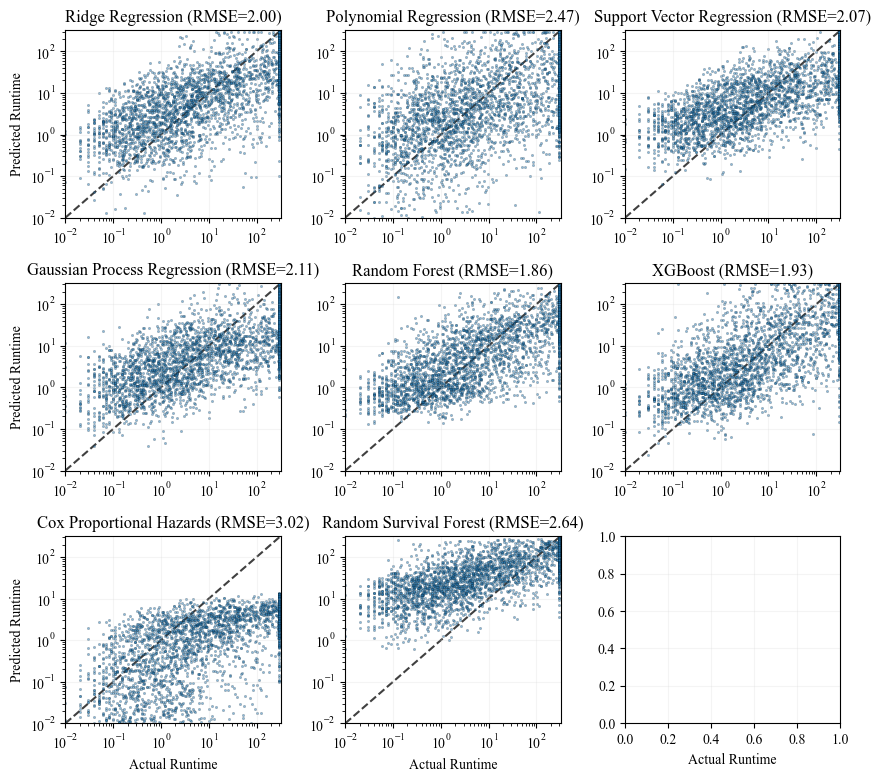

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 9))
axs = axs.flatten()

for i, model_info in enumerate(models.values()):
    ax = axs[i]
    result = model_info["result"]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{model_info["name"]} (RMSE={result["rmse"]:.2f})')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[6].set_ylabel("Predicted Runtime")
axs[6].set_xlabel("Actual Runtime")
axs[7].set_xlabel("Actual Runtime")
axs[8].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
# plt.savefig("runtime_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

## N

In [17]:
models = {
    "rr": {
        "model": Ridge(**ridge_incumbent),
        "name": "Ridge Regression",
    },
    "pr": {
        "model": PolynomialRidge(**poly_ridge_incumbent),
        "name": "Polynomial Regression",
    },
    "svr": {
        "model": SVR(**svr_incumbent),
        "name": "Support Vector Regression",
    },
    "gpr": {
        "model": GPRWithRBF(**gpr_incumbent),
        "name": "Gaussian Process Regression",
    },
    "rf": {
        "model": RandomForestRegressor(**rf_incumbent),
        "name": "Random Forest",
    },
    "xgb": {
        "model": XGBRegressor(**xgb_incumbent),
        "name": "XGBoost",
    },
}

In [18]:
records = []
for model_info in models.values():
    for seed in [0]:
        for solver_number in [8, 12, 16, 22, 32, 46, 64, 90, 128, 180, 256, 362, 512, 724]:
            print(model_info["name"], solver_number)
            result = evaluate_model_with_cross_validation(
                df,
                model_info["model"],
                n=2,
                instance_number=10,
                solver_number=solver_number,
                random_state=seed,
            )
            records.append({
                "seed": seed,
                "model_name": model_info["name"],
                "solver_number": solver_number,
                "rmse": result["rmse"],
                "cc": result["cc"],
                "r2": result["r2"],
            })

Ridge Regression 8
Ridge Regression 12
Ridge Regression 16
Ridge Regression 22
Ridge Regression 32
Ridge Regression 46
Ridge Regression 64
Ridge Regression 90
Ridge Regression 128
Ridge Regression 180
Ridge Regression 256
Ridge Regression 362
Ridge Regression 512
Ridge Regression 724
Polynomial Regression 8
Polynomial Regression 12
Polynomial Regression 16
Polynomial Regression 22
Polynomial Regression 32
Polynomial Regression 46
Polynomial Regression 64
Polynomial Regression 90
Polynomial Regression 128
Polynomial Regression 180
Polynomial Regression 256
Polynomial Regression 362
Polynomial Regression 512
Polynomial Regression 724
Support Vector Regression 8
Support Vector Regression 12
Support Vector Regression 16
Support Vector Regression 22
Support Vector Regression 32
Support Vector Regression 46
Support Vector Regression 64
Support Vector Regression 90
Support Vector Regression 128
Support Vector Regression 180
Support Vector Regression 256
Support Vector Regression 362
Support V

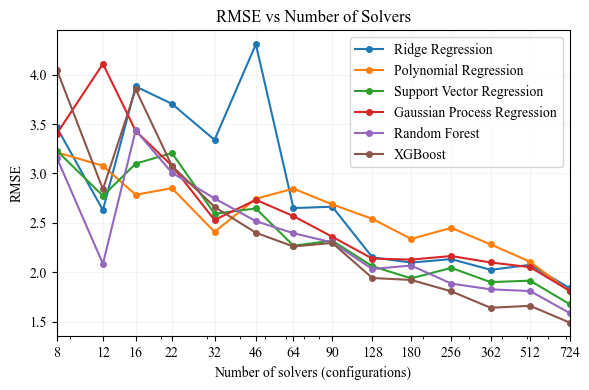

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

df_plot = pd.DataFrame(records).fillna(0)
df_plot = df_plot.groupby(["model_name", "solver_number"]).mean().reset_index()

colors = plt.cm.tab10(range(len(models)))
color_map = {model_info["name"]: colors[i] for i, model_info in enumerate(models.values())}

for model_info in models.values():
    model_name = model_info["name"]
    group = df_plot[df_plot['model_name'] == model_name].sort_values('solver_number')
    plt.plot(
        group['solver_number'], 
        group['rmse'], 
        'o-', 
        label=model_name,
        color=color_map[model_name],
        linewidth=1.5,
        markersize=4
    )

plt.xscale('log')
plt.xlabel('Number of solvers (configurations)')
plt.ylabel('RMSE')
plt.legend(loc='best', frameon=True)
plt.xticks(df_plot['solver_number'].unique(), df_plot['solver_number'].unique())
plt.title('RMSE vs Number of Solvers')
plt.tight_layout()
# plt.savefig("rmse_vs_solver_number.png", dpi=300, bbox_inches="tight")
plt.show()